<a href="https://www.kaggle.com/code/aleksandrmorozov123/machine-learning-excercises?scriptVersionId=96143713" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/the-boston-houseprice-data/boston.csv


# **I am pleased that such a large number of views of this notebook. Removed broken code cells**

**Import required libraries**

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import (
    ensemble, 
    preprocessing, 
    tree,
)
from sklearn.metrics import (
auc,
confusion_matrix,
roc_auc_score,
roc_curve
)
from sklearn.model_selection import (
train_test_split,
)
from yellowbrick.classifier import (
ConfusionMatrix,
ROCAUC,
)
from yellowbrick.model_selection import (
LearningCurve,
)

**Read the data Titanic dataset**

In [47]:
df = pd.read_csv ('../input/titanic/train.csv')
orig_df = df

df.head (10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q  
6      0             17463  51.8625   E46        S  
7      1            349909  21.0750   NaN        S  
8      2            347742  11.1333   NaN        S  
9      0            237736  30.0708   NaN        C

**Cleaning the data**

In [48]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [49]:
import pandas_profiling
pandas_profiling.ProfileReport (df)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [50]:
df.shape

(891, 12)

In [51]:
df.describe ().iloc[:, :2]

PassengerId    Survived
count   891.000000  891.000000
mean    446.000000    0.383838
std     257.353842    0.486592
min       1.000000    0.000000
25%     223.500000    0.000000
50%     446.000000    0.000000
75%     668.500000    1.000000
max     891.000000    1.000000

In [52]:
df.isnull ().sum ()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [53]:
df.isnull ().sum (axis = 1).loc[:10]

0     1
1     0
2     1
3     0
4     1
5     2
6     0
7     1
8     1
9     1
10    0
dtype: int64

In [54]:
mask = df.isnull ().any (axis = 1)
mask.head ()  # rows

0     True
1    False
2     True
3    False
4     True
dtype: bool

In [55]:
df [mask].Embarked.head ()

0    S
2    S
4    S
5    Q
7    S
Name: Embarked, dtype: object

In [56]:
df.Sex.value_counts (dropna = False)

male      577
female    314
Name: Sex, dtype: int64

In [57]:
df.Embarked.value_counts (dropna = False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [58]:
df = df.drop (
     columns = [
         "Name",
         "Ticket",
         "Cabin"
])
df = pd.get_dummies (df)
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

**Sample data**

In [59]:
from sklearn.model_selection import train_test_split
y = df.Survived
X = df.drop (columns = "Survived")

**Impute data**

In [60]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 42)

from sklearn.experimental import enable_iterative_imputer
from sklearn import impute
num_cols = ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

imputer = impute.IterativeImputer ()
imputed = imputer.fit_transform (
X_train [num_cols])
X_train.loc [:, num_cols] = imputed

meds = X_train.median ()
X_train = X_train.fillna (meds)
X_test = X_test.fillna (meds)

**Normalize data**

In [61]:
cols = "PassengerId, Pclass, Age, SibSp, Parch, Fare, Sex_female, Sex_male, Embarked_C, Embarked_Q, Embarked_S".split (",")
sca = preprocessing.StandardScaler ()
X_train = sca.fit_transform (X_train)
X_train = pd.DataFrame (X_train, columns = cols)
X_test = sca.transform (X_test)
X_test = pd.DataFrame (X_test, columns = cols)

**Refactor**

In [62]:
from sklearn.model_selection import train_test_split
def tweak_titanic (df):
    df = df.drop (
    columns = [
        "PassengerId",
        "Name",
        "Ticket",
        "Cabin",
    ]
    ).pipe (pd.get_dummies, drop_first = True)
    return df

def get_train_test_X_y (
df, y_col, size = 0.3, std_cols = None
):
    y = df [y_col]
    X = df.drop (columns = y_col)
    X_train, X_test, y_train, y_test = train_test_split (
    X, y, test_size = size, random_state = 42
    )
    cols = X.columns
    num_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 
                'Sex_male', 'Embarked_Q', 'Embarked_S']
    fi = impute.IterativeImputer ()
    X_train.loc [
        :, num_cols
    ] = fi.fit_transform (X_train [num_cols])
    X_test.loc [:, num_cols] = fi.transform (
    X_test [num_cols])
    
    if std_cols:
        std = preprocessing.StandardScaler ()
        X_train.loc [
            :, std_cols
        ] = std.fit_transform (
        X_train [std_cols])
        
        X_test.loc [
            :, std_cols
        ] = std.transform (X_test [std_cols])
        return X_train, X_test, y_train, y_test
    
ti_df = tweak_titanic (orig_df)
std_cols = "Pclass".split (",")
X_train, X_test, y_train, y_test = get_train_test_X_y (ti_df, "Survived", std_cols = std_cols)

**Baseline model**

In [63]:
from sklearn.dummy import DummyClassifier
bm = DummyClassifier ()
bm.fit (X_train, y_train)
bm.score (X_test, y_test) # accuracy

0.585820895522388

**K-fold cross-validation**

In [64]:
X = pd.concat ([X_train, X_test])
y = pd.concat ([y_train, y_test])
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

for model in [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier, 
    GaussianNB,
    SVC,
    RandomForestClassifier,
    ]:
    cls = model ()
    kfold = model_selection.KFold (n_splits=10, random_state=None)
    s = model_selection.cross_val_score (
    cls, X, y, scoring = 'roc_auc', cv = kfold)

    print (f"{model.__name__:22}   AUC: "
          f"{s.mean (): .3f} STD: {s.std(): .2f}")

DummyClassifier          AUC:  0.500 STD:  0.00


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression       AUC:  0.851 STD:  0.06
DecisionTreeClassifier   AUC:  0.767 STD:  0.04
KNeighborsClassifier     AUC:  0.750 STD:  0.05
GaussianNB               AUC:  0.832 STD:  0.06
SVC                      AUC:  0.751 STD:  0.06
RandomForestClassifier   AUC:  0.861 STD:  0.05


**Staking**

In [65]:
from mlxtend.classifier import StackingClassifier
clfs = [
    x()
    for x in [
        LogisticRegression,
        DecisionTreeClassifier,
        GaussianNB,
        SVC,
        RandomForestClassifier
    ]
]
stack = StackingClassifier (classifiers=clfs,
                          meta_classifier = LogisticRegression ())
kfold = model_selection.KFold (n_splits = 10, random_state = None)

s = model_selection.cross_val_score (stack, X, y, scoring = 'roc_auc', cv = kfold)

print (f"{stack.__class__.__name__}  "
      f"AUC: {s.mean():.3f}  STD: {s.std():.2f}")

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


StackingClassifier  AUC: 0.840  STD: 0.05


**Create and evaluate Model**

In [66]:
# create model
rf = ensemble.RandomForestClassifier (n_estimators = 100, random_state = 42)
rf.fit (X_train, y_train)

# evaluate model
rf.score (X_test, y_test)

0.7649253731343284

In [67]:
# metrics precision
metrics.precision_score (y_test, rf.predict (X_test))

0.7264150943396226

In [68]:
# inspect feature performance
for col, val in sorted (zip (X_train.columns, rf.feature_importances_),
                       key = lambda x: x[1], reverse = True,
                       )[:5]:
    print (f"{col:10}{val:10.3f}")

Age            0.274
Fare           0.267
Sex_male       0.243
Pclass         0.082
SibSp          0.056


**Optimize model**

In [69]:
rf4 = ensemble.RandomForestClassifier ()
params = {
    "max_features": [0.4, "auto"],
    "n_estimators": [15, 200],
    "min_samples_leaf": [1, 0.1],
    "random_state": [42],
}
cv = model_selection.GridSearchCV (rf4, params, n_jobs=-1
                                  ).fit(X_train, y_train)
print (cv.best_params_)

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 15, 'random_state': 42}


In [70]:
rf5 = ensemble.RandomForestClassifier (
**{
    "max_features": "auto",
    "min_samples_leaf": 0.1,
    "n_estimators": 200,
    "random_state": 42,
})
rf5.fit (X_train, y_train)

rf5.score (X_test, y_test)

0.7686567164179104

**Confusion matrix**

In [71]:
from sklearn.metrics import confusion_matrix
y_pred = rf5.predict (X_test)
confusion_matrix (y_test, y_pred)

array([[148,   9],
       [ 53,  58]])

/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


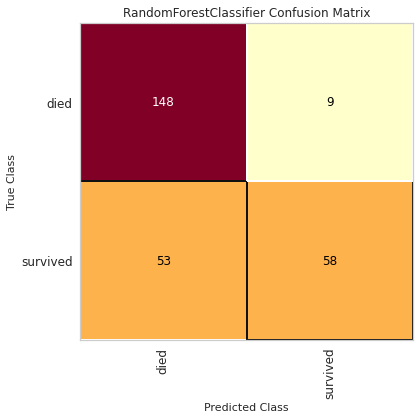

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [72]:
mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots (figsize = (6, 6))
cm_viz = ConfusionMatrix (rf5, classes = ["died", "survived"],
                         label_encoder = mapping)
cm_viz.score (X_test, y_test)
cm_viz.poof ()

**ROC Curve**

In [73]:
y_pred = rf5.predict (X_test)
roc_auc_score (y_test, y_pred)

0.7325988408790957

**Learning curve**

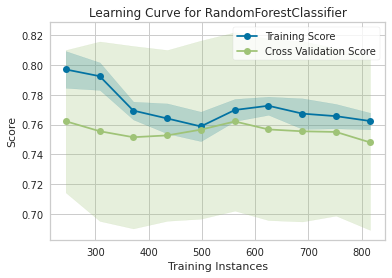

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [74]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

fig, ax = plt.subplots (figsize = (6, 4))
cv = StratifiedKFold (12)
sizes = np.linspace (0.3, 1.0, 10)
lc_viz = LearningCurve (
rf5, 
cv = cv,
train_sizes = sizes,
scoring = "f1_weighted",
n_jobs = 4,
ax = ax)

lc_viz.fit (X, y)
lc_viz.poof ()

**Deploing model**

In [75]:
import pickle
pic = pickle.dumps (rf5)
rf6 = pickle.loads (pic)
y_pred = rf6.predict (X_test)
roc_auc_score (y_test, y_pred)

0.7325988408790957

# **The model did not show the most optimal result, so let's start all over again and carefully work through each step of titanic dataset**

**Examining missing data**

In [76]:
df.isnull ().mean () * 100

PassengerId     0.00000
Survived        0.00000
Pclass          0.00000
Age            19.86532
SibSp           0.00000
Parch           0.00000
Fare            0.00000
Sex_female      0.00000
Sex_male        0.00000
Embarked_C      0.00000
Embarked_Q      0.00000
Embarked_S      0.00000
dtype: float64

**Using missingno library**

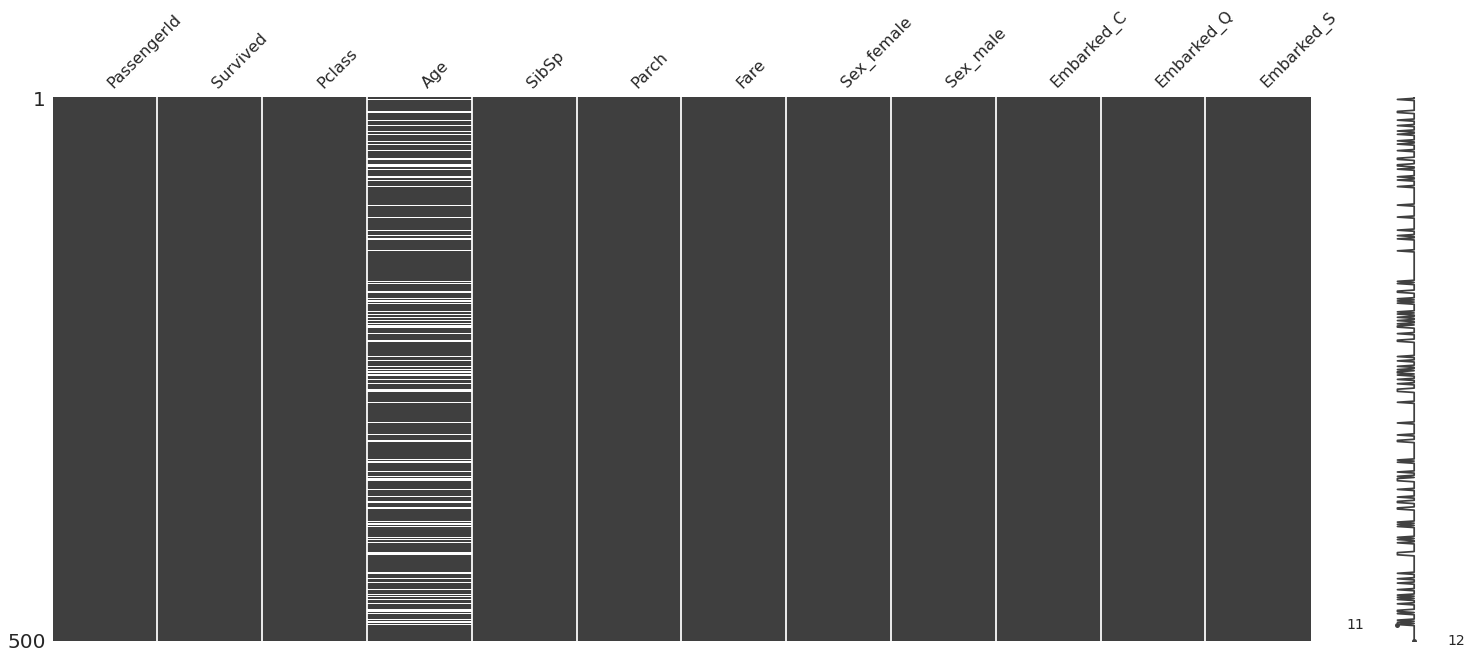

In [77]:
import missingno as msno
ax = msno.matrix (df.sample (500))

**Bar plot**

<AxesSubplot:>

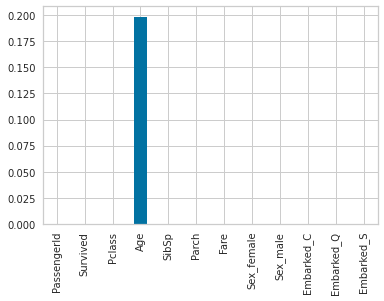

In [78]:
fig, ax = plt.subplots (figsize = (6, 4))
(df.isnull().mean().abs().plot.bar (ax=ax))

**Missingno library bar plot**

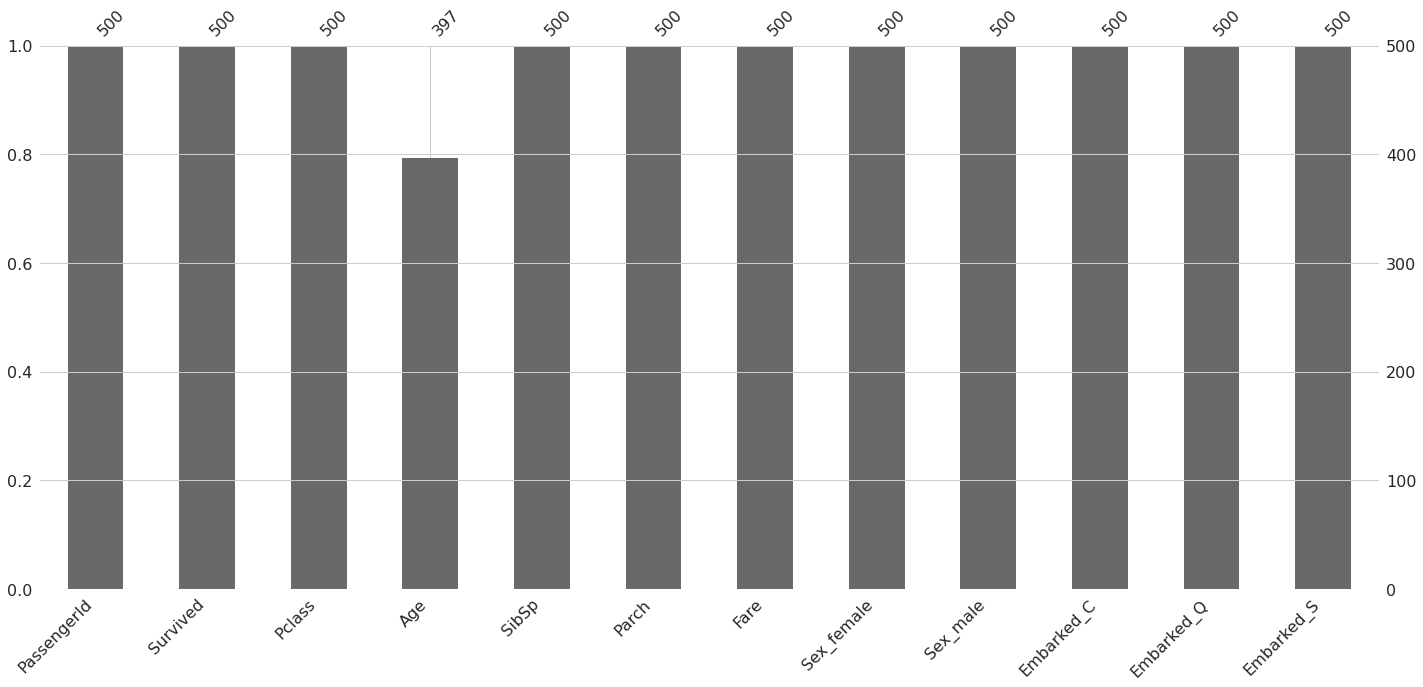

In [79]:
ax = msno.bar (df.sample (500))

**Create a dendrogram**

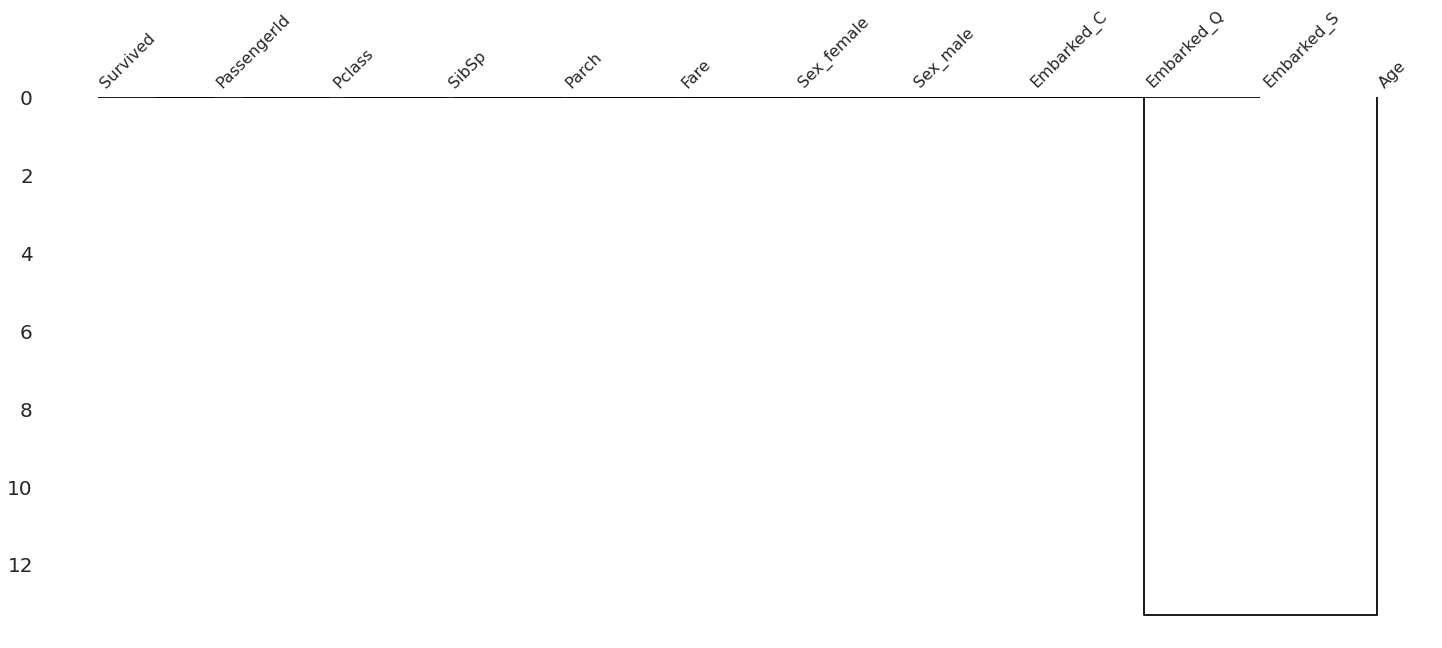

In [81]:
ax = msno.dendrogram (df)

**Dropping missnig data**

In [85]:
df1 = orig_df.dropna ()
df1 = orig_df.drop (columns = "Cabin")
df1 = orig_df.dropna (axis = 1)

**Imputing data**

In [83]:
from sklearn.impute import SimpleImputer 
num_cols = df.select_dtypes (include = "number").columns
im = SimpleImputer ()  # mean
imputed = im.fit_transform (df[num_cols])

**Adding indicator columns**

In [86]:
def add_indicator (col):
    def wrapper (df):
        return df[col].isna().astype (int)
    
    return wrapper

df1 = df.assign (cabin_missing = add_indicator ("Age"))

**Exploring data**

In [87]:
df.shape 

(891, 12)

In [88]:
df.describe ().iloc [:, [0, -1]]

PassengerId  Embarked_S
count   891.000000  891.000000
mean    446.000000    0.722783
std     257.353842    0.447876
min       1.000000    0.000000
25%     223.500000    0.000000
50%     446.000000    1.000000
75%     668.500000    1.000000
max     891.000000    1.000000

In [89]:
df.iloc [[1, 4], -3:]

Embarked_C  Embarked_Q  Embarked_S
1           1           0           0
4           0           0           1

In [91]:
df.loc [[101, 417], "Embarked_C":]

Embarked_C  Embarked_Q  Embarked_S
101           0           0           1
417           0           0           1

In [92]:
df.head (5)

PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare  Sex_female  \
0            1         0       3  22.0      1      0   7.2500           0   
1            2         1       1  38.0      1      0  71.2833           1   
2            3         1       3  26.0      0      0   7.9250           1   
3            4         1       1  35.0      1      0  53.1000           1   
4            5         0       3  35.0      0      0   8.0500           0   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0         1           0           0           1  
1         0           1           0           0  
2         0           0           0           1  
3         0           0           0           1  
4         1           0           0           1

**Histogram**

<AxesSubplot:ylabel='Frequency'>

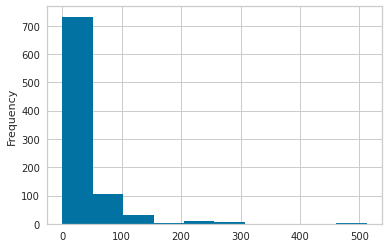

In [93]:
fig, ax = plt.subplots (figsize = (6, 4))
df.Fare.plot (kind ="hist", ax=ax)

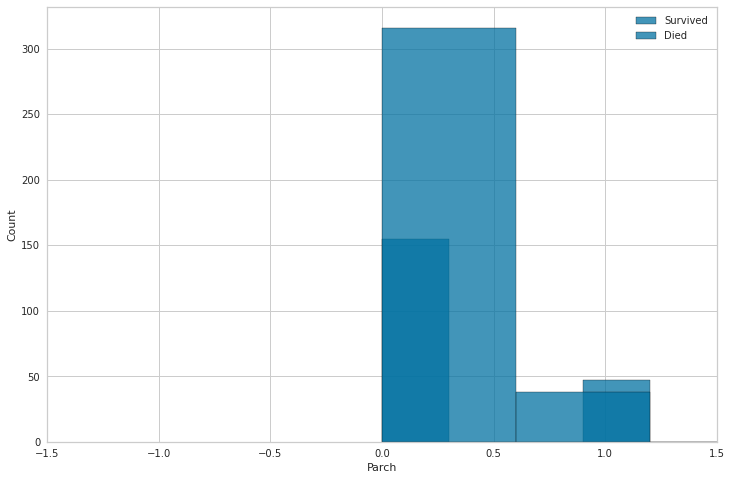

In [94]:
import seaborn as sns
fig, ax = plt.subplots (figsize = (12, 8))
mask = y_train == 1
ax = sns.histplot (X_train [mask].Parch, label = 'Survived')
ax = sns.histplot (X_train [~mask].Parch, label = 'Died')
ax.set_xlim(-1.5, 1.5)
ax.legend ()

**Scatter plot**

<AxesSubplot:xlabel='Age', ylabel='Fare'>

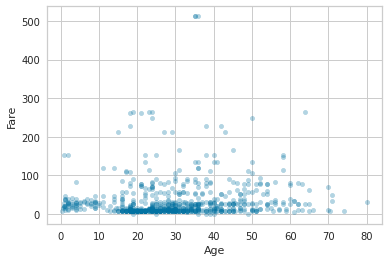

In [95]:
fig, ax = plt.subplots (figsize= (6, 4))
df.plot.scatter (x = "Age", y = "Fare", ax = ax, alpha = 0.3)

In [96]:
df.Parch.corr (df.Age)

-0.18911926263203518

**Joint plot**

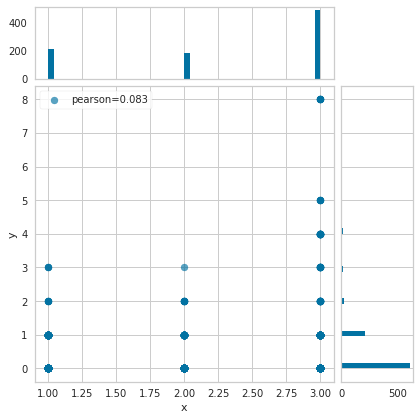

<AxesSubplot:xlabel='x', ylabel='y'>

In [97]:
from yellowbrick.features import JointPlotVisualizer

fig, ax = plt.subplots (figsize = (6, 6))
jpv = JointPlotVisualizer (feature = "Pclass", target = "SibSp")
jpv.fit (df["Pclass"], df["SibSp"])
jpv.poof ()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


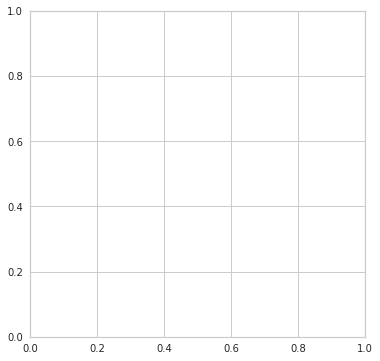

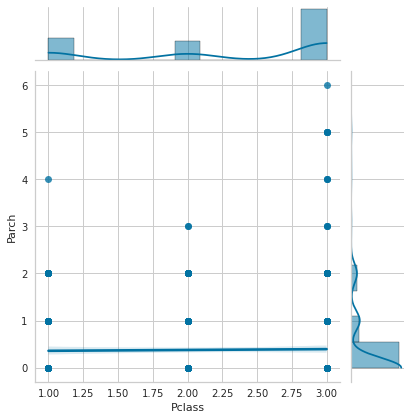

In [98]:
# use seaborn library to create a joint plot
from seaborn import jointplot
fig, ax = plt.subplots (figsize = (6, 6))
new_df = df.copy ()
new_df = df.copy ()
new_df["target"] = y
p = jointplot ("Pclass", "Parch", data = new_df, kind = "reg")

**Pair grid**

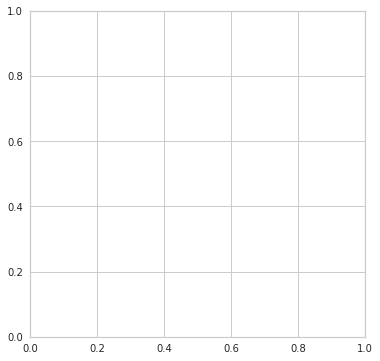

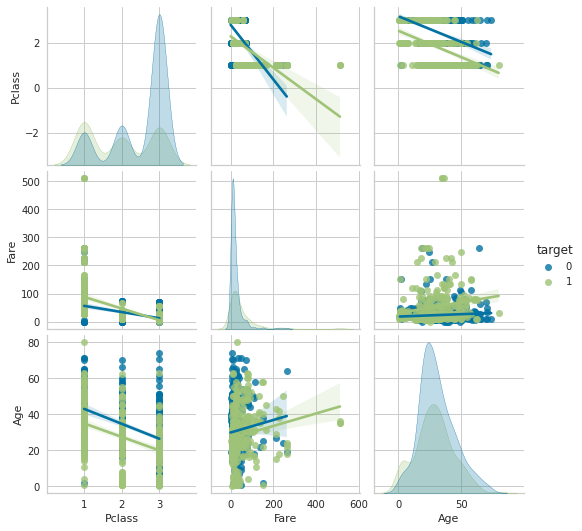

In [99]:
from seaborn import pairplot
fig, ax = plt.subplots(figsize = (6, 6))
new_df = df.copy ()
new_df ["target"] = y
vars = ["Pclass", "Fare", "Age"]
p = pairplot (new_df, vars = vars, hue = "target", kind = "reg")

**Box and violin plots**

<AxesSubplot:xlabel='target', ylabel='Age'>

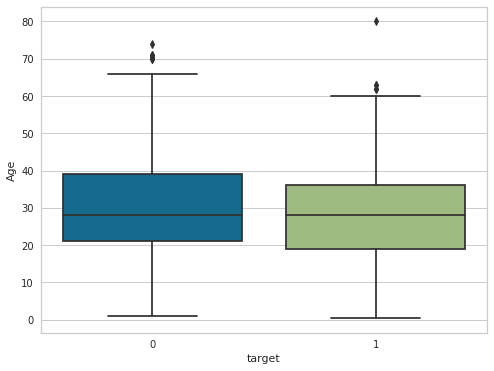

In [100]:
from seaborn import boxplot
fig, ax = plt.subplots (figsize = (8, 6))
new_df = df.copy ()
new_df ["target"] = y
boxplot (x = "target", y = "Age", data= new_df)

<AxesSubplot:xlabel='target', ylabel='Age'>

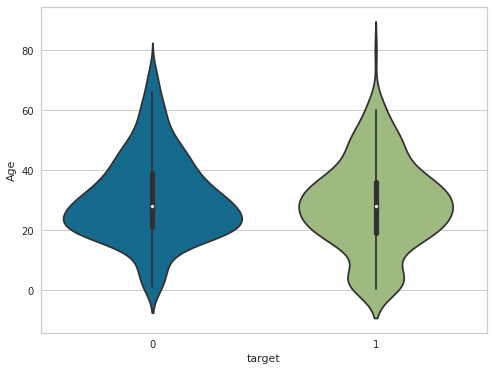

In [101]:
from seaborn import violinplot
fig, ax= plt.subplots (figsize = (8, 6))
new_df = df.copy ()
new_df ["target"] = y
violinplot (x = "target", y = "Age", data = new_df)

**Comparing two ordinal values**

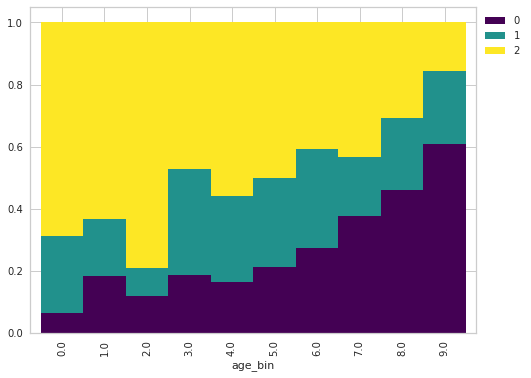

In [102]:
fig, ax = plt.subplots (figsize = (8, 6))
(df.assign (age_bin = pd.qcut (df.Age, q = 10, labels = False),
          class_bin = pd.cut (df.Pclass, bins = 3, labels = False),
          ).pipe (lambda df: pd.crosstab (df.age_bin, df.class_bin))
 .pipe (lambda df: df.div (df.sum (1), axis = 0))
 .plot.bar (stacked = True,
           width = 1,
           ax = ax,
           cmap = 'viridis',
           )
 .legend (bbox_to_anchor = (1, 1)))

**Correlation**

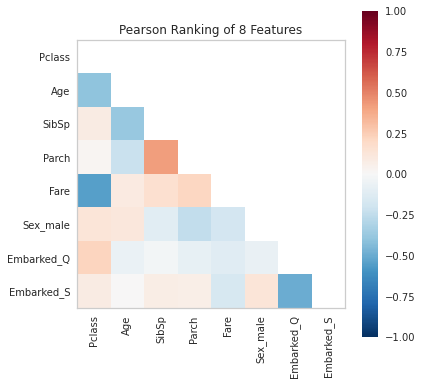

<AxesSubplot:title={'center':'Pearson Ranking of 8 Features'}>

In [103]:
from yellowbrick.features import Rank2D
fig, ax = plt.subplots (figsize = (6, 6))
pcv = Rank2D (features = X.columns, algorithm = "pearson")
pcv.fit (X, y)
pcv.transform (X)
pcv.poof ()

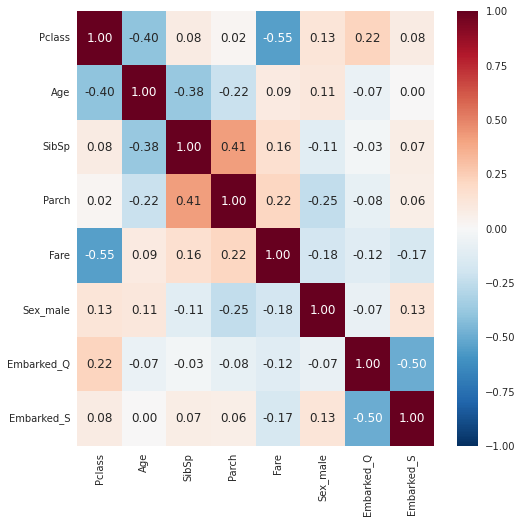

In [104]:
from seaborn import heatmap
fig, ax = plt.subplots (figsize = (8, 8))
ax = heatmap (
X.corr (),
fmt = ".2f",
annot = True,
ax = ax,
cmap = "RdBu_r",
vmin = -1,
vmax = 1)

In [105]:
df.corr ().iloc [:, :2]

PassengerId  Survived
PassengerId     1.000000 -0.005007
Survived       -0.005007  1.000000
Pclass         -0.035144 -0.338481
Age             0.036847 -0.077221
SibSp          -0.057527 -0.035322
Parch          -0.001652  0.081629
Fare            0.012658  0.257307
Sex_female     -0.042939  0.543351
Sex_male        0.042939 -0.543351
Embarked_C     -0.001205  0.168240
Embarked_Q     -0.033606  0.003650
Embarked_S      0.022148 -0.155660

In [106]:
def correlated_columns (df, threshold = 0.95):
    return (df.corr ().pipe (
    lambda df1: pd.DataFrame (np.tril (df1, k=-1),
                             columns = df.columns,
                             index = df.columns)).stack ()
           .rename ("pearson").pipe (lambda s: s [
               s.abs () > threshold].reset_index ())
           .query ("level_0 not in level_1"))

correlated_columns (df)

level_0     level_1  pearson
0  Sex_male  Sex_female     -1.0

**RadViz**

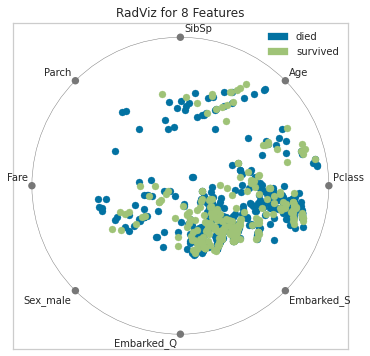

<AxesSubplot:title={'center':'RadViz for 8 Features'}>

In [107]:
from yellowbrick.features import RadViz
fig, ax = plt.subplots (figsize = (6, 6))
rv = RadViz (classes = ["died", "survived"],
            features = X.columns)
rv.fit (X, y)
_ = rv.transform (X)
rv.poof ()

<AxesSubplot:>

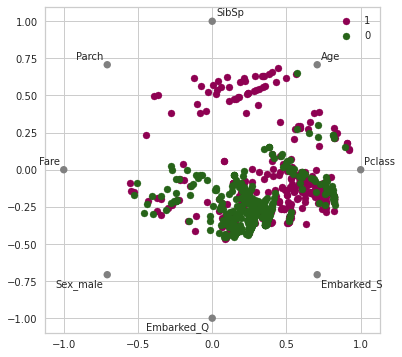

In [108]:
# pandas library can plot RadViz
from pandas.plotting import radviz
fig, ax = plt.subplots (figsize = (6, 6))
new_df = X.copy ()
new_df ["target"] = y
radviz (new_df, "target", ax = ax, colormap = "PiYG")

**Parallel coordinates**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


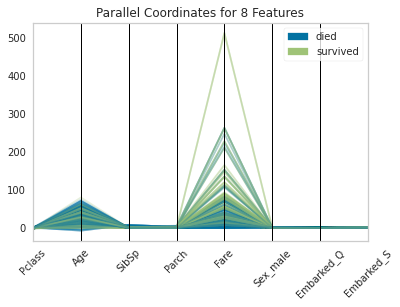

<AxesSubplot:title={'center':'Parallel Coordinates for 8 Features'}>

In [109]:
from yellowbrick.features import ParallelCoordinates
fig, ax = plt.subplots (figsize = (6, 4))
pc = ParallelCoordinates (classes = ["died", "survived"],
                         features = X.columns)
pc.fit (X, y)
pc.transform (X)
ax.set_xticklabels (ax.get_xticklabels (), rotation = 45)
pc.poof ()

[Text(0, 0, 'Pclass'),
 Text(1, 0, 'Age'),
 Text(2, 0, 'SibSp'),
 Text(3, 0, 'Parch'),
 Text(4, 0, 'Fare'),
 Text(5, 0, 'Sex_male'),
 Text(6, 0, 'Embarked_Q'),
 Text(7, 0, 'Embarked_S')]

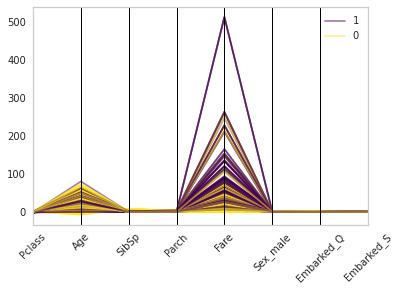

In [110]:
# pandas library can plot parallel coordinates
from pandas.plotting import parallel_coordinates
fig, ax = plt.subplots (figsize = (6, 4))
new_df = X.copy ()
new_df ["target"] = y
parallel_coordinates (new_df, "target", ax = ax, colormap = "viridis", alpha = 0.5)
ax.set_xticklabels (ax.get_xticklabels (), rotation = 45)

**Standardize data**

In [111]:
from sklearn import preprocessing
X2 = df
std = preprocessing.StandardScaler ()
std.fit_transform (X)

array([[-1.56610693, -1.8462086 , -0.4745452 , ...,  0.73769513,
        -0.30756234,  0.61930636],
       [ 0.82737724, -0.0325133 , -0.4745452 , ...,  0.73769513,
        -0.30756234,  0.61930636],
       [ 0.82737724, -2.06615035,  0.43279337, ..., -1.35557354,
        -0.30756234,  0.61930636],
       ...,
       [-1.56610693,  2.62594028, -0.4745452 , ...,  0.73769513,
        -0.30756234,  0.61930636],
       [ 0.82737724, -0.89312769, -0.4745452 , ...,  0.73769513,
        -0.30756234,  0.61930636],
       [-1.56610693, -0.08667461, -0.4745452 , ...,  0.73769513,
        -0.30756234,  0.61930636]])

In [112]:
std.scale_

array([ 1.01991414, 13.63997524,  1.10212444,  0.80560476, 49.66553444,
        0.47772176,  0.28098288,  0.44762435])

In [ ]:
std.mean_

In [ ]:
std.var_

In [ ]:
X_std = (X2 - X2.mean ()) / X2.std ()
X_std

In [ ]:
X_std.mean ()

In [ ]:
X_std.std ()

**Scale to range**

In [113]:
from sklearn import preprocessing
mms = preprocessing.MinMaxScaler ()
mms.fit (X2)
mms.transform (X2)

array([[0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.0011236 , 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.00224719, 1.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.99775281, 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.9988764 , 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ]])

In [114]:
# pandas preprocessing
(X2 - X2.min ()) / (X2.max () - X2.min ())

PassengerId  Survived  Pclass       Age  SibSp     Parch      Fare  \
0       0.000000       0.0     1.0  0.271174  0.125  0.000000  0.014151   
1       0.001124       1.0     0.0  0.472229  0.125  0.000000  0.139136   
2       0.002247       1.0     1.0  0.321438  0.000  0.000000  0.015469   
3       0.003371       1.0     0.0  0.434531  0.125  0.000000  0.103644   
4       0.004494       0.0     1.0  0.434531  0.000  0.000000  0.015713   
..           ...       ...     ...       ...    ...       ...       ...   
886     0.995506       0.0     0.5  0.334004  0.000  0.000000  0.025374   
887     0.996629       1.0     0.0  0.233476  0.000  0.000000  0.058556   
888     0.997753       0.0     1.0       NaN  0.125  0.333333  0.045771   
889     0.998876       1.0     0.0  0.321438  0.000  0.000000  0.058556   
890     1.000000       0.0     1.0  0.396833  0.000  0.000000  0.015127   

     Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0           0.0       1.0         0.0         0.0         1.0  
1           1.0       0.0         1.0         0.0         0.0  
2           1.0       0.0         0.0         0.0         1.0  
3           1.0       0.0         0.0         0.0         1.0  
4           0.0       1.0         0.0         0.0         1.0  
..          ...       ...         ...         ...         ...  
886         0.0       1.0         0.0         0.0         1.0  
887         1.0       0.0         0.0         0.0         1.0  
888         1.0       0.0         0.0         0.0         1.0  
889         0.0       1.0         1.0         0.0         0.0  
890         0.0       1.0         0.0         1.0         0.0  

[891 rows x 12 columns]

**Dummy variables**

In [115]:
pd.get_dummies (df, drop_first = True)

PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare  Sex_female  \
0              1         0       3  22.0      1      0   7.2500           0   
1              2         1       1  38.0      1      0  71.2833           1   
2              3         1       3  26.0      0      0   7.9250           1   
3              4         1       1  35.0      1      0  53.1000           1   
4              5         0       3  35.0      0      0   8.0500           0   
..           ...       ...     ...   ...    ...    ...      ...         ...   
886          887         0       2  27.0      0      0  13.0000           0   
887          888         1       1  19.0      0      0  30.0000           1   
888          889         0       3   NaN      1      2  23.4500           1   
889          890         1       1  26.0      0      0  30.0000           0   
890          891         0       3  32.0      0      0   7.7500           0   

     Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0           1           0           0           1  
1           0           1           0           0  
2           0           0           0           1  
3           0           0           0           1  
4           1           0           0           1  
..        ...         ...         ...         ...  
886         1           0           0           1  
887         0           0           0           1  
888         0           0           0           1  
889         1           1           0           0  
890         1           0           1           0  

[891 rows x 12 columns]

**Label encoder**

In [116]:
df1 = pd.read_csv ('../input/titanic/train.csv')
df1.head (5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [117]:
from sklearn import preprocessing
lab = preprocessing.LabelEncoder ()
lab.fit_transform (df1.Name)

array([108, 190, 353, 272,  15, 554, 515, 624, 412, 576, 727,  95, 729,
        28, 840, 359, 682, 867, 839, 512, 273,  80, 523, 765, 626,  44,
       240, 260, 605, 813, 828, 776, 289, 856, 535, 372, 505, 134, 837,
       589,   7, 827, 446, 456, 212, 697, 473, 604, 726,  38, 629, 594,
       333, 246, 620, 873, 707, 595, 853, 299, 749, 385, 337, 755, 784,
       560, 596, 185,  25, 440, 396, 300, 376, 161,  87, 546, 778, 563,
       127, 223, 842, 737, 519, 141, 386,  52, 255, 764, 259, 149, 159,
        31, 150, 209, 184, 740, 292, 308, 219, 422, 656, 658, 858, 405,
       312, 542, 724, 559, 675, 552, 667, 882,  67, 417,  46, 645, 178,
       826,  70,  24, 362, 551, 575, 848, 857, 588, 525, 499, 653, 234,
       225, 165, 695, 851, 772, 685, 585, 271, 618, 282,  99, 597, 319,
       116,  32, 586,  29, 254, 580, 121,  68, 643, 532, 889, 612, 866,
       287, 181, 767, 716, 186, 847,  82, 129, 628, 293, 157, 760,  69,
       486, 832, 680, 408, 752, 769, 444, 464, 388, 320, 474, 71

In [118]:
lab.inverse_transform ([1, 1, 0])

array(['Abbott, Mr. Rossmore Edward', 'Abbott, Mr. Rossmore Edward',
       'Abbing, Mr. Anthony'], dtype=object)

In [119]:
df1.Name.astype ("category").cat.as_ordered ().cat.codes + 1


0      109
1      191
2      354
3      273
4       16
      ... 
886    549
887    304
888    414
889     82
890    221
Length: 891, dtype: int16

**Frequency encoding**

In [120]:
from collections import Counter
c = Counter ()
def triples (val):
    for i in range (len(val)):
        c[val[i : i + 3]] += 1
df1.Name.apply (triples)
c.most_common (10)

[(', M', 870),
 (' Mr', 642),
 ('r. ', 568),
 ('Mr.', 517),
 ('s. ', 309),
 ('n, ', 218),
 (' Mi', 197),
 ('iss', 183),
 ('ss.', 183),
 ('Mis', 182)]

In [ ]:
df1.Name.str.extract ("([A-Za-z]+)\.", expand = False).head ()

In [ ]:
df1.Name.str.extract ("([A-Za-z]+)\.", expand = False).value_counts ()

**Other categorical encoding**

In [121]:
import category_encoders as ce
he = ce.HashingEncoder (verbose = 1)
he.fit_transform (df1)

col_0  col_1  col_2  col_3  col_4  col_5  col_6  col_7  PassengerId  \
0        1      0      1      0      0      2      1      0            1   
1        0      0      0      0      1      2      0      2            2   
2        2      0      0      0      1      1      1      0            3   
3        0      0      1      1      0      1      1      1            4   
4        1      0      0      0      2      1      1      0            5   
..     ...    ...    ...    ...    ...    ...    ...    ...          ...   
886      1      0      0      1      0      1      2      0          887   
887      0      0      0      0      1      1      2      1          888   
888      1      1      0      0      0      1      2      0          889   
889      0      1      0      0      1      1      0      2          890   
890      1      1      1      0      0      1      1      0          891   

     Survived  Pclass   Age  SibSp  Parch     Fare  
0           0       3  22.0      1      0   7.2500  
1           1       1  38.0      1      0  71.2833  
2           1       3  26.0      0      0   7.9250  
3           1       1  35.0      1      0  53.1000  
4           0       3  35.0      0      0   8.0500  
..        ...     ...   ...    ...    ...      ...  
886         0       2  27.0      0      0  13.0000  
887         1       1  19.0      0      0  30.0000  
888         0       3   NaN      1      2  23.4500  
889         1       1  26.0      0      0  30.0000  
890         0       3  32.0      0      0   7.7500  

[891 rows x 15 columns]

**Feature selection - Collinear columns**

In [126]:
cols_to_remove = [
    "Pclass",
    "SibSp",
    "Parch",
    "Embarked_Q"
]
rf3 = RandomForestClassifier (random_state = 42)
rf3.fit (X_train [[c for c in X_train.columns
                 if c not in cols_to_remove]], y_train)
rf3.score (X_test [[c for c in X_train.columns
                   if c not in cols_to_remove]], y_test)

0.7425373134328358

In [127]:
rf4 = RandomForestClassifier (random_state = 42)
rf4.fit (X_train, y_train)
rf4.score (X_test, y_test)

0.7649253731343284

**Recursive feature elimination**

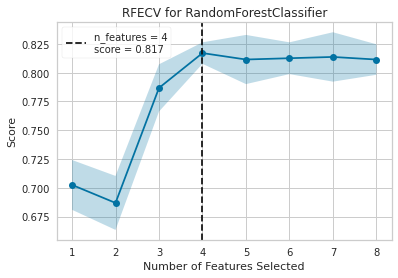

<AxesSubplot:title={'center':'RFECV for RandomForestClassifier'}, xlabel='Number of Features Selected', ylabel='Score'>

In [129]:
from yellowbrick.features import RFECV
fig, ax = plt.subplots (figsize = (6, 4))
rfe = RFECV (ensemble.RandomForestClassifier (n_estimators = 100), cv = 5)
rfe.fit (X, y)

rfe.rfe_estimator_.ranking_

rfe.rfe_estimator_.n_features_

rfe.rfe_estimator_.support_

rfe.poof ()

**Mutual information between feature and target**

<AxesSubplot:ylabel='feature'>

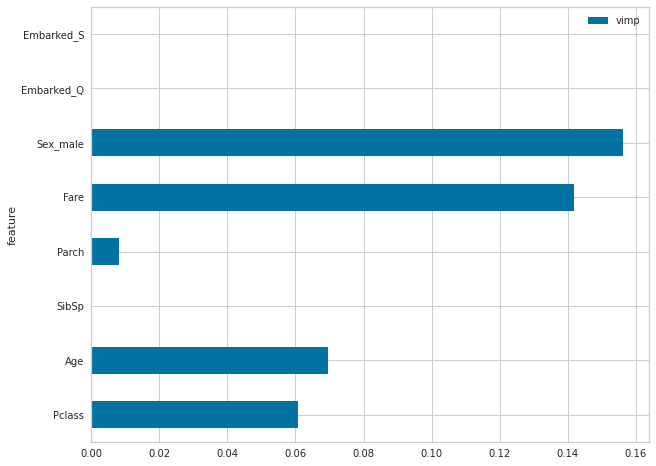

In [132]:
from sklearn import feature_selection
mic = feature_selection.mutual_info_classif (X, y)
fig, ax = plt.subplots (figsize = (10, 8))
(pd.DataFrame ({"feature":X.columns, "vimp": mic}).set_index ("feature").plot.barh (ax = ax))

**Unsampling minority**

In [134]:
from sklearn.utils import resample
mask = df.Survived == 1
surv_df = df [mask]
death_df = df[~mask]
df_usample = resample (surv_df, replace = True, n_samples = len (death_df), random_state = 42)
df2 = pd.concat ([death_df, df_usample])
df2.Survived.value_counts ()

0    549
1    549
Name: Survived, dtype: int64

**Downsampling majority**

In [137]:
from sklearn.utils import resample
mask = df.Survived == 1
surv_df = df [mask]
death_df = df[~mask]
df_downsample = resample (death_df, replace = False, n_samples = len (surv_df), random_state = 42)
df3 = pd.concat ([surv_df, df_downsample])
df3.Survived.value_counts ()

1    342
0    342
Name: Survived, dtype: int64

**Logistic regression**

In [138]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression (random_state = 42)
lr.fit (X_train, y_train)
lr.score (X_test, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8134328358208955

In [139]:
lr.predict_proba (X.iloc [[1]])

array([[0.89733036, 0.10266964]])

In [ ]:
lr.predict_log_proba (X.iloc [[2]])

In [ ]:
lr.decision_function (X.iloc [[3]])

In [ ]:
lr.intercept_

In [140]:
def inv_logit (p):
    return np.exp (p) / (1 + np.exp (p))

inv_logit (lr.intercept_)

array([0.90976419])

In [141]:
# inspect the coefficients

cols = X.columns
for col, val in sorted (zip (cols, lr.coef_[0]), key = lambda x: x[1], reverse = True):
    print (f"{col:10}{val:10.3f} {inv_logit (val):10.3f}")

Embarked_Q     0.178      0.544
Fare           0.003      0.501
Age           -0.036      0.491
Parch         -0.048      0.488
SibSp         -0.319      0.421
Embarked_S    -0.459      0.387
Pclass        -0.821      0.306
Sex_male      -2.346      0.087


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


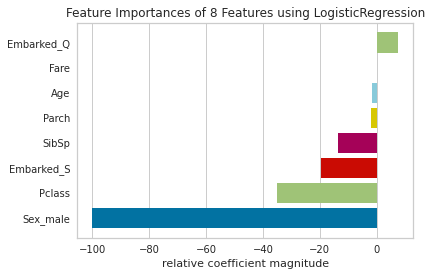

<AxesSubplot:title={'center':'Feature Importances of 8 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [142]:
# inspect coefficients with yellowbrick

from yellowbrick.model_selection import FeatureImportances
fig, ax = plt.subplots (figsize = (6, 4))
fi_viz = FeatureImportances (lr)
fi_viz.fit (X, y)
fi_viz.poof ()

**Naive Bayes**

In [143]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB ()
nb.fit (X_train, y_train)
nb.score (X_test, y_test)

0.7985074626865671

In [144]:
nb.predict_proba (X.iloc [[1]])

array([[0.96002595, 0.03997405]])

In [ ]:
nb.predict_log_proba (X.iloc [[2]])

**Support vector machine (SVM)**

In [145]:
# scikit-learn's SVM implementation

from sklearn.svm import SVC
svc = SVC (random_state = 42, probability = True)
svc.fit (X_train, y_train)
svc.score (X_test, y_test)

0.6567164179104478

In [ ]:
svc.predict_proba (X.iloc [[2]])

In [ ]:
svc.predict_log_proba (X.iloc [[3]])

**K-Nearest Neighbor**

In [146]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier ()
knc.fit (X_train, y_train)
knc.score (X_test, y_test)

0.7164179104477612

In [ ]:
knc.predict_proba (X.iloc [[1]])

**Decision Tree**

In [147]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier (random_state = 42, max_depth = 3)
dt.fit (X_train, y_train)
dt.score (X_test, y_test)

0.8097014925373134

In [ ]:
dt.predict_proba (X.iloc [[1]])

In [ ]:
dt.predict_proba (X.iloc [[2]])

In [ ]:
dt.predict_log_proba (X.iloc [[3]])

In [148]:
# feature importance

for col, val in sorted (
    zip (X.columns, dt.feature_importances_),
    key = lambda x: x[1],reverse = True) [:5]:
    print (f"{col:10}{val:10.3f}") 

Sex_male       0.589
Pclass         0.181
Fare           0.095
SibSp          0.070
Age            0.064


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


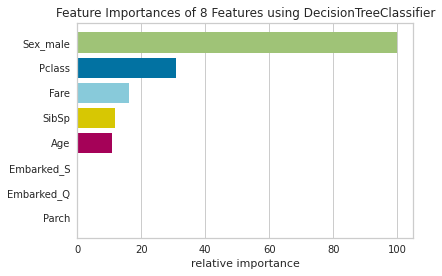

<AxesSubplot:title={'center':'Feature Importances of 8 Features using DecisionTreeClassifier'}, xlabel='relative importance'>

In [149]:
# feature importance

from yellowbrick.model_selection import FeatureImportances
fig, ax = plt.subplots (figsize = (6, 4))
fi_viz = FeatureImportances (dt)
fi_viz.fit (X, y)
fi_viz.poof ()

**Random Forest**

In [150]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier (random_state = 42)
rf.fit (X_train, y_train)

rf.score (X_test, y_test)

0.7649253731343284

In [ ]:
rf.predict_proba (X.iloc [[1]])

In [ ]:
rf.predict_log_proba (X.iloc [[1]])

In [151]:
# feature importance
for col, val in sorted (zip (X.columns, rf.feature_importances_),
                       key = lambda x: x[1], reverse = True) [:5]:
    print (f"{col:10}{val:10.3f}")

Age            0.274
Fare           0.267
Sex_male       0.243
Pclass         0.082
SibSp          0.056


**XGBoost**

In [152]:
import xgboost as xgb
xgb_class = xgb.XGBClassifier (random_state = 42, use_label_encoder=False) 
xgb_class.fit (X_train, y_train, early_stopping_rounds = 10, eval_set = [(X_test, y_test)])

xgb_class.score (X_test, y_test)

[18:01:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.57058
[1]	validation_0-logloss:0.50587
[2]	validation_0-logloss:0.47309
[3]	validation_0-logloss:0.45755
[4]	validation_0-logloss:0.44565
[5]	validation_0-logloss:0.44016
[6]	validation_0-logloss:0.43847
[7]	validation_0-logloss:0.43924
[8]	validation_0-logloss:0.43607
[9]	validation_0-logloss:0.44022
[10]	validation_0-logloss:0.44361
[11]	validation_0-logloss:0.44767
[12]	validation_0-logloss:0.44999
[13]	validation_0-logloss:0.45057
[14]	validation_0-logloss:0.44491
[15]	validation_0-logloss:0.44387
[16]	validation_0-logloss:0.44723
[17]	validation_0-logloss:0.45474
[18]	validation_0-logloss:0.45658


0.8022388059701493

In [ ]:
xgb_class.predict_proba (X.iloc [[1]])

In [153]:
# feature importance
for col, val in sorted (zip (X.columns, xgb_class.feature_importances_), key = lambda x: x[1],
                       reverse = True)[:5]:
    print (f"{col:10}{val:10.3f}")

Sex_male       0.596
Pclass         0.199
SibSp          0.048
Embarked_S     0.038
Embarked_Q     0.032


In [ ]:
fig, ax = plt.subplots (figsize = (6, 4))
xgb.plot_importance (xgb_class, ax = ax)

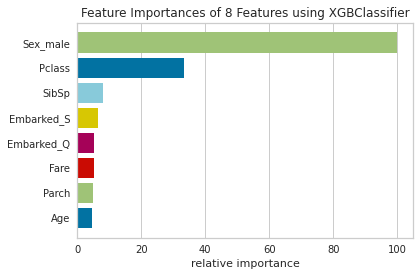

<AxesSubplot:title={'center':'Feature Importances of 8 Features using XGBClassifier'}, xlabel='relative importance'>

In [154]:
fig, ax = plt.subplots (figsize = (6, 4))
fi_viz = FeatureImportances (xgb_class)
fi_viz.fit (X, y)
fi_viz.poof ()

In [155]:
# text representation of the trees

booster = xgb_class.get_booster ()
print (booster.get_dump () [0])

0:[Sex_male<0.5] yes=1,no=2,missing=1
	1:[Pclass<0.192980036] yes=3,no=4,missing=3
		3:leaf=0.536842108
		4:[Fare<23.3500004] yes=7,no=8,missing=7
			7:[Embarked_S<0.5] yes=13,no=14,missing=13
				13:[Fare<15.3729] yes=19,no=20,missing=19
					19:[Fare<8.08334923] yes=31,no=32,missing=31
						31:leaf=0.25
						32:leaf=-0.200000018
					20:leaf=0.41538465
				14:[Fare<10.8249998] yes=21,no=22,missing=21
					21:[Fare<7.69999981] yes=33,no=34,missing=33
						33:leaf=0.300000012
						34:leaf=-0.288888901
					22:[Fare<17.7000008] yes=35,no=36,missing=35
						35:leaf=0.247058839
						36:leaf=-0.100000009
			8:leaf=-0.436363667
	2:[Age<6.5] yes=5,no=6,missing=5
		5:[SibSp<3] yes=9,no=10,missing=9
			9:leaf=0.458823562
			10:leaf=-0.360000014
		6:[Fare<52.2770996] yes=11,no=12,missing=11
			11:[Pclass<-1.02759421] yes=15,no=16,missing=15
				15:[Fare<30.75] yes=23,no=24,missing=23
					23:[Fare<29.8500004] yes=37,no=38,missing=37
						37:leaf=-0.230769247
						38:leaf=0.120000005
			

In [ ]:
# score from first tree leaf 7
1 / (1 + np.exp (- 1 * 0.1535))

In [ ]:
# graphical version tree model

fig, ax = plt.subplots (figsize = (16, 12))
xgb.plot_tree (xgb_class, ax = ax, num_trees = 0)

**Gradient Boosted with LightGBM**

In [156]:
import lightgbm as lgb
lgbm_class =lgb.LGBMClassifier (random_state = 42)
lgbm_class.fit (X_train, y_train)

lgbm_class.score (X_test, y_test)

0.7947761194029851

In [ ]:
lgbm_class.predict_proba (X.iloc [[1]])

In [ ]:
lgbm_class.predict_proba (X.iloc[[2]])

In [157]:
# feature importance based on 'splits'

for col, val in sorted (zip (cols, lgbm_class.feature_importances_),
                       key = lambda x: x[1], reverse = True)[:5]:
    print (f"{col:10}{val:10.3f}")

Fare        1016.000
Age          926.000
Pclass       103.000
Embarked_S    97.000
SibSp         83.000


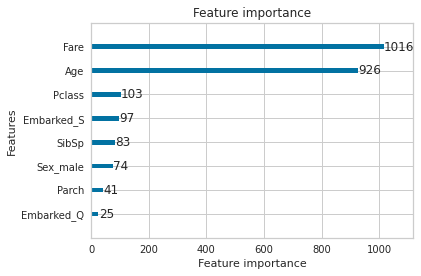

In [158]:
fig, ax = plt.subplots (figsize = (6, 4))
lgb.plot_importance (lgbm_class, ax = ax)
fig.tight_layout ()

In [ ]:
fig, ax = plt.subplots (figsize = (16, 12))
lgb.plot_tree (lgbm_class, tree_index = 0, ax = ax)

**TPOT**

In [159]:
from tpot import TPOTClassifier
tc = TPOTClassifier (generations = 2)
tc.fit (X_train, y_train)
tc.score (X_test, y_test)

0.8022388059701493

In [ ]:
tc.predict_proba (X.iloc [[1]])

**Learning Curve**

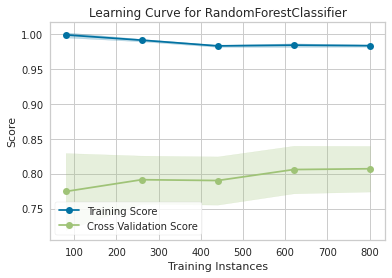

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [160]:
from yellowbrick.model_selection import LearningCurve
fig, ax = plt.subplots (figsize = (6, 4))
lc3_viz = LearningCurve (RandomForestClassifier (n_estimators = 100), cv = 10)
lc3_viz.fit (X, y)
lc3_viz.poof ()

**Validation Curve**

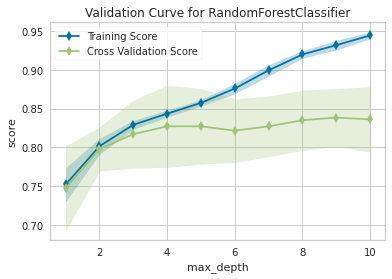

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='max_depth', ylabel='score'>

In [162]:
from yellowbrick.model_selection import ValidationCurve
fig, ax = plt.subplots (figsize = (6, 4))
vc_viz = ValidationCurve (RandomForestClassifier (n_estimators = 100),
                         param_name = "max_depth", param_range = np.arange (1, 11),
                          cv = 10, n_jobs = -1)
vc_viz.fit (X, y)
vc_viz.poof()

**Confusion matrix**

In [163]:
y_predict = dt.predict (X_test)
tp = ((y_test == 1) & (y_test == y_predict)).sum () # 123
tn = ((y_test == 0) & (y_test == y_predict)).sum () # 199
fp = ((y_test == 0) & (y_test != y_predict)).sum () # 25
fn = ((y_test == 1) & (y_test != y_predict)).sum () # 46

In [164]:
from sklearn.metrics import confusion_matrix
y_predict = dt.predict (X_test)
pd.DataFrame (confusion_matrix (y_test, y_predict), columns = ["Predict died", "Predict Survive"],
             index = ["True Death", "True Survive"])

Predict died  Predict Survive
True Death             139               18
True Survive            33               78

/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


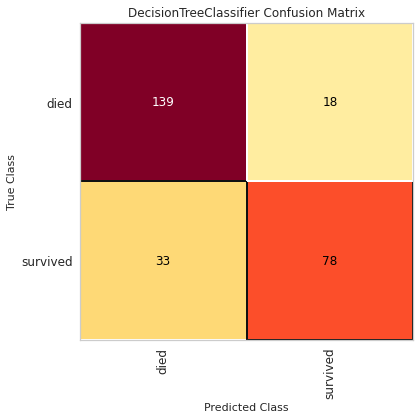

<AxesSubplot:title={'center':'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [165]:
import matplotlib.pyplot as plt
from yellowbrick.classifier import ConfusionMatrix
mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots (figsize = (6, 6))
cm_viz = ConfusionMatrix (dt, classes = ["died", "survived"],
                         label_encoder = mapping)
cm_viz.score (X_test, y_test)
cm_viz.poof ()

**Metrics**

In [166]:
# accuracy 
(tp + tn) / (tp + tn + fp + fn)

0.8097014925373134

In [167]:
# accuracy from sklearn
from sklearn.metrics import accuracy_score
y_predict = dt.predict (X_test)
accuracy_score (y_test, y_predict)

0.8097014925373134

In [ ]:
# recall
tp / (tp + fn)

In [168]:
# recall from sklearn
from sklearn.metrics import recall_score
y_predict = dt.predict (X_test)
recall_score (y_test, y_predict)

0.7027027027027027

In [ ]:
# precision
tp / (tp + fp)

In [169]:
# precision from sklearn
from sklearn.metrics import precision_score
y_predict = dt.predict (X_test)
precision_score (y_test, y_predict)

0.8125

In [ ]:
# F1
pre = tp / (tp + fp)
rec = tp / (tp + fn)
(2 * pre * rec) / (pre + rec)

In [171]:
# F1 from sklearn 
from sklearn.metrics import f1_score
y_predict = dt.predict (X_test)
f1_score (y_test, y_predict)

0.7536231884057971

**Classification report**

/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


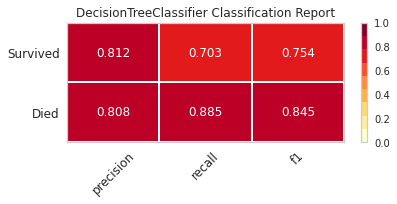

<AxesSubplot:title={'center':'DecisionTreeClassifier Classification Report'}>

In [170]:
import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
fig, ax = plt.subplots (figsize = (6, 3))
cm_viz = ClassificationReport (dt, classes = ["Died", "Survived"],
                              label_encoder = mapping)
cm_viz.score (X_test, y_test)
cm_viz.poof ()

**Precision-Recall curve**

In [172]:
from sklearn.metrics import average_precision_score
y_predict = dt.predict (X_test)
average_precision_score (y_test, y_predict)

0.6940802743041549

0.7495037617563546


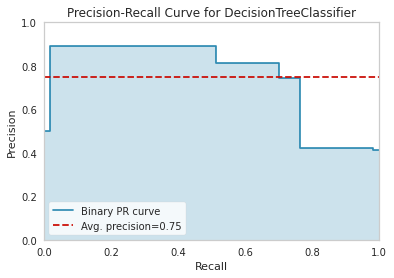

<AxesSubplot:title={'center':'Precision-Recall Curve for DecisionTreeClassifier'}, xlabel='Recall', ylabel='Precision'>

In [173]:
from yellowbrick.classifier import PrecisionRecallCurve
fig, ax = plt.subplots (figsize = (6, 4))
viz = PrecisionRecallCurve (DecisionTreeClassifier (max_depth = 3))
viz.fit (X_train, y_train)
print (viz.score (X_test, y_test))
viz.poof ()

**Cumulative Gains Plot**

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

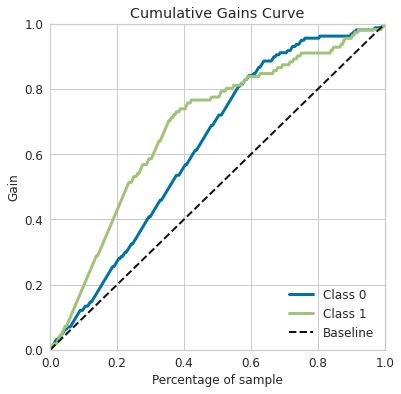

In [174]:
import scikitplot as skplt
fig, ax = plt.subplots (figsize = (6, 6))
y_probas = dt.predict_proba (X_test)
skplt.metrics.plot_cumulative_gain (y_test, y_probas, ax = ax)

**Lift Curve**

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

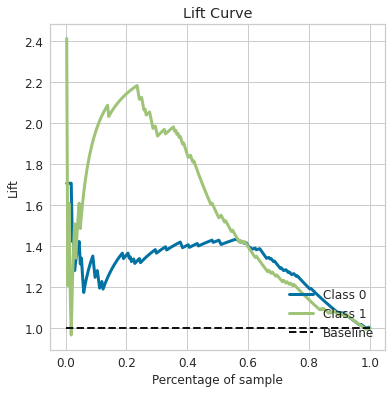

In [175]:
fig, ax = plt.subplots (figsize = (6, 6))
y_probas = dt.predict_proba (X_test)
skplt.metrics.plot_lift_curve (y_test, y_probas, ax = ax)

**Class Balance**

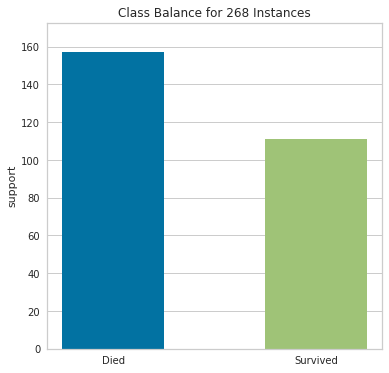

<AxesSubplot:title={'center':'Class Balance for 268 Instances'}, ylabel='support'>

In [176]:
from yellowbrick.classifier import ClassBalance
fig, ax = plt.subplots (figsize = (6, 6))
cb_viz = ClassBalance (labels = ["Died", "Survived"])
cb_viz.fit (y_test)
cb_viz.poof ()

**Class Prediction error**

/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


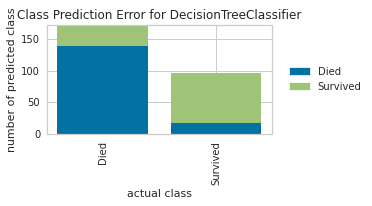

<AxesSubplot:title={'center':'Class Prediction Error for DecisionTreeClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [177]:
from yellowbrick.classifier import ClassPredictionError
fig, ax = plt.subplots (figsize = (6, 3))
cpe_viz = ClassPredictionError (dt, classes = ["Died", "Survived"])
cpe_viz.score (X_test, y_test)
cpe_viz.poof ()

**Discrimination Threshold**

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


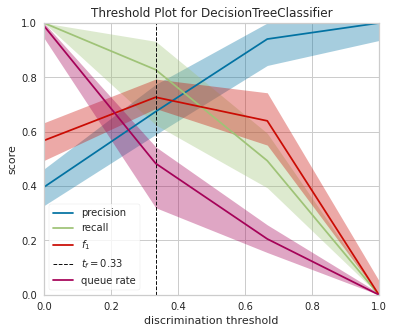

<AxesSubplot:title={'center':'Threshold Plot for DecisionTreeClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [178]:
from yellowbrick.classifier import DiscriminationThreshold
fig, ax = plt.subplots (figsize = (6, 5))
dt_viz = DiscriminationThreshold (dt)
dt_viz.fit (X, y)
dt_viz.poof ()

**Regression Coefficients**

In [179]:
dt = DecisionTreeClassifier (random_state = 42, max_depth = 3)
dt.fit (X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


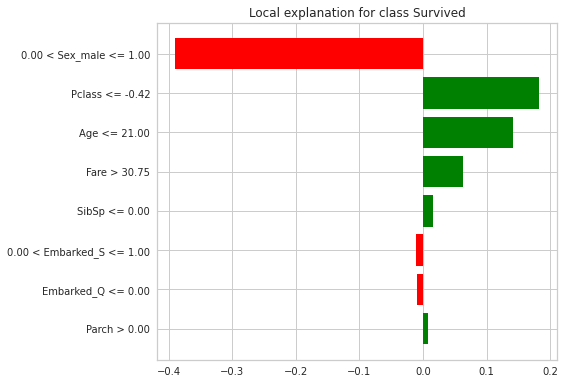

In [180]:
# LIME
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer (X_train.values, feature_names = X.columns,
                                              class_names = ["Died", "Survived"])
exp = explainer.explain_instance (X_train.iloc [-1].values, dt.predict_proba)
fig = exp.as_pyplot_figure ()
fig.tight_layout ()

**Partial dependence plots**

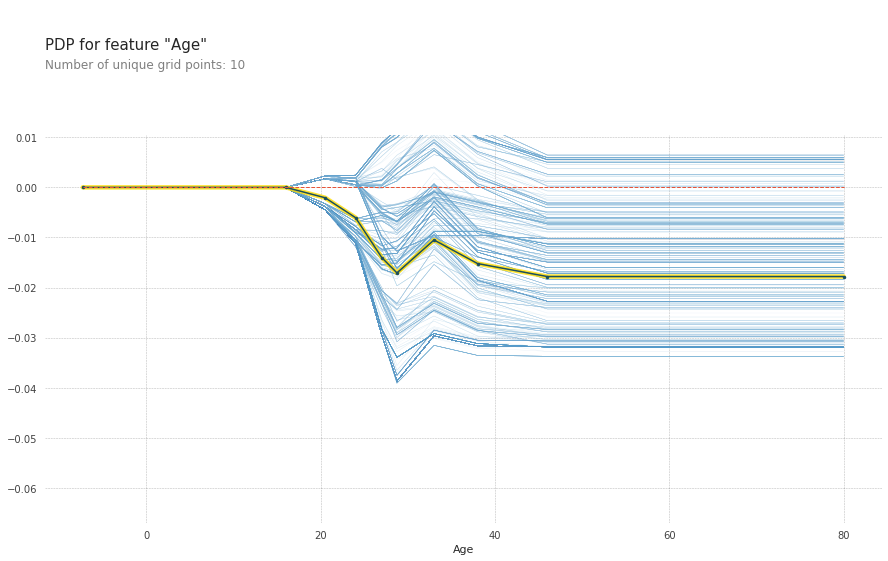

In [181]:
rf5 = ensemble.RandomForestClassifier (**{"max_features": "auto",
                                         "min_samples_leaf": 0.1,
                                         "n_estimators": 200,
                                         "random_state": 42})
rf5.fit (X_train, y_train)

from pdpbox import pdp
feat_name = "Age"
p = pdp.pdp_isolate (rf5, X, X.columns, feat_name)
fig, _ = pdp.pdp_plot (p, feat_name, plot_lines = True)

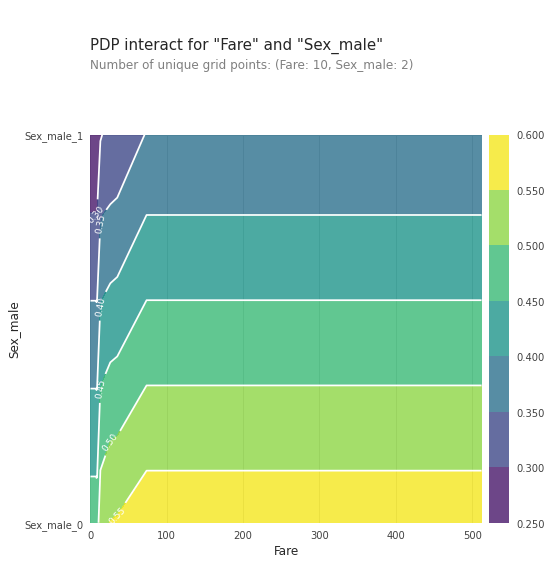

In [182]:
features = ["Fare", "Sex_male"]
p = pdp.pdp_interact (rf5, X, X.columns, features)
fig, _ = pdp.pdp_interact_plot (p, features)

**Surrogate models**

In [183]:
from sklearn import svm
sv = svm.SVC ()
sv.fit (X_train, y_train)
sur_dt = tree.DecisionTreeClassifier ()
sur_dt.fit (X_test, sv.predict (X_test))
for col, val in sorted (zip (X_test.columns,
                            sur_dt.feature_importances_),
                       key = lambda x: x[1], reverse = True)[:7]:
    print (f"{col:10}{val:10.3f}")

Fare           1.000
Pclass         0.000
Age            0.000
SibSp          0.000
Parch          0.000
Sex_male       0.000
Embarked_Q     0.000


**Regression**

In [184]:
import pandas as pd
from sklearn import model_selection
from sklearn.model_selection import train_test_split

In [185]:
# load the Boston housing dataset
import pandas as pd
import numpy as np

b = pd.read_csv ('../input/the-boston-houseprice-data/boston.csv')

# create a split version for training and testing data
bos_X = b
bos_y = b['CRIM']

bos_X_train, bos_X_test, bos_y_train, bos_y_test = train_test_split (bos_X, bos_y, test_size = 0.3, random_state = 42)

bos_sX = preprocessing.StandardScaler ().fit_transform (bos_X)
bos_sX_train, bos_sX_test, bos_sy_train, bos_sy_test = train_test_split (
bos_sX, bos_y, test_size = 0.3, random_state = 42)

**Baseline model**

In [186]:
from sklearn.dummy import DummyRegressor
dr = DummyRegressor ()
dr.fit (bos_X_train, bos_y_train)
dr.score (bos_X_test, bos_y_test)

-0.0026881950074355565

**Linear regression**

In [187]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression ()
lr.fit (bos_X_train, bos_y_train)
lr.score (bos_X_test, bos_y_test)

1.0

In [ ]:
lr.coef_

In [188]:
lr2 = LinearRegression ()
lr2.fit (bos_sX_train, bos_sy_train)
lr2.score (bos_sX_test, bos_sy_test)

1.0

In [ ]:
lr2.intercept_

In [ ]:
lr2.coef_

**K-Nearest Neighbor**

In [189]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor ()
knr.fit (bos_sX_train, bos_sy_train)
knr.score (bos_sX_test, bos_sy_test)

0.8696209493763742

**Decision tree**

In [190]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor (random_state = 42)
dtr.fit (bos_X_train, bos_y_train)
dtr.score (bos_X_test, bos_y_test)

0.9567189153568749

In [191]:
# feature importance

for col, val in sorted (zip (bos_X.columns, dtr.feature_importances_),
                       key = lambda x: x[1], reverse = True)[:5]:
    print (f"{col:10}{val:10.3f}")

CRIM           0.970
RM             0.024
DIS            0.006
AGE            0.000
NOX            0.000


**Random forest**

In [192]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor (random_state = 42, n_estimators = 100)
rfr.fit (bos_X_train, bos_y_train)
rfr.score (bos_X_test, bos_y_test)

0.9837623959959247

In [193]:
# feature importance
for col, val in sorted (zip (bos_X.columns, rfr.feature_importances_),
                       key = lambda x: x[1], reverse = True)[:5]:
    print (f"{col:10}{val:10.3f}")

CRIM           0.954
RM             0.013
MEDV           0.012
B              0.010
DIS            0.004


**LightGBM Regression**

In [194]:
import lightgbm as lgb
lgr = lgb.LGBMRegressor (random_state = 42)
lgr.fit (bos_X_train, bos_y_train)
lgr.score (bos_X_test, bos_y_test)

0.6718852726243931

In [ ]:
lgr.predict (bos_X.iloc [[0]])

In [195]:
# feature importances
for col, val in sorted (zip (bos_X.columns, lgr.feature_importances_),
                       key = lambda x: x[1], reverse = True)[:5]:
    print (f"{col:10}{val:10.3f}")

CRIM         402.000
DIS          161.000
LSTAT        140.000
B            129.000
MEDV         119.000


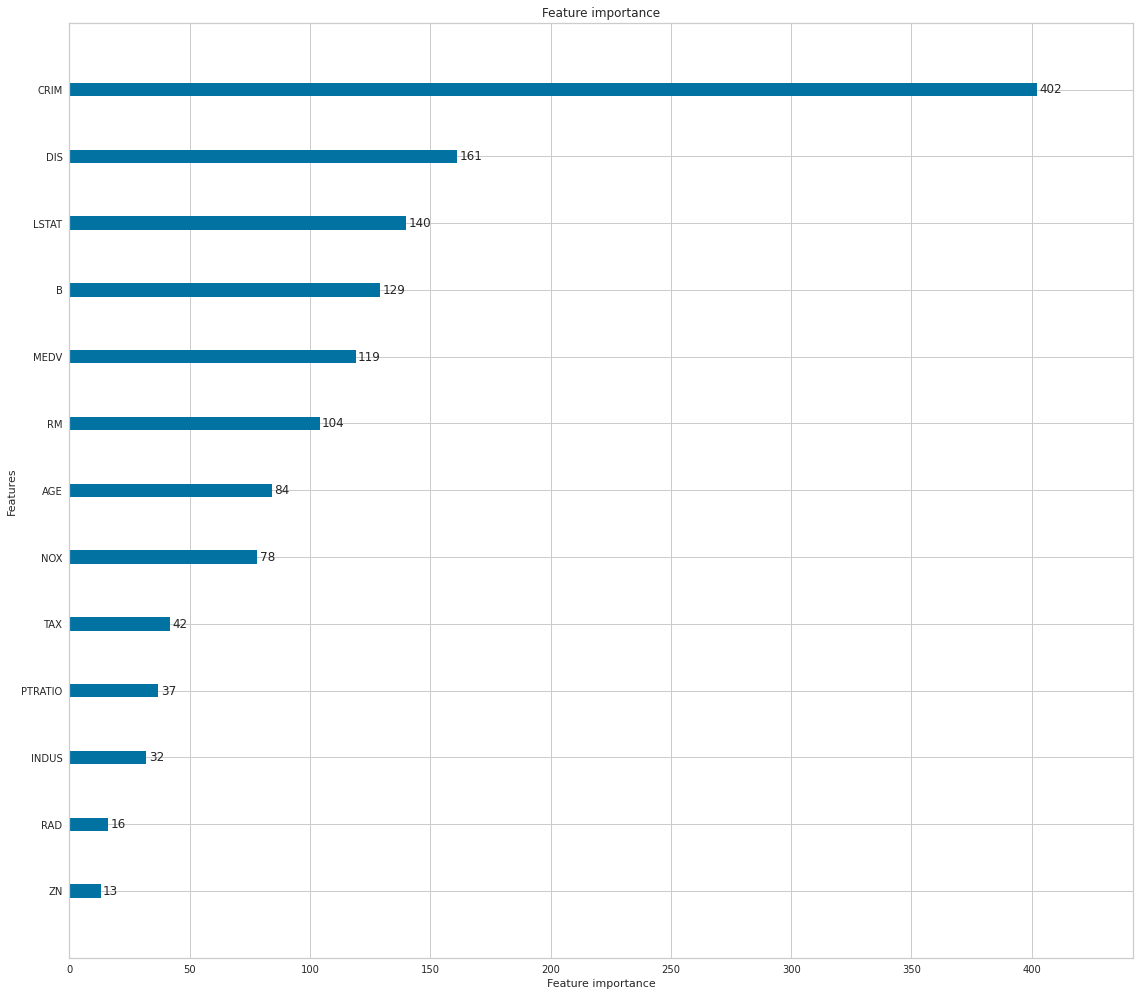

In [196]:
fig, ax= plt.subplots (figsize = (16, 14))
lgb.plot_importance (lgr, ax = ax)
fig.tight_layout ()

**Metrics**

In [197]:
rfr = RandomForestRegressor (random_state = 42, n_estimators = 100)
rfr.fit (bos_X_train, bos_y_train)

from sklearn import metrics
rfr.score (bos_X_test, bos_y_test)

0.9837623959959247

**Residuals plot**

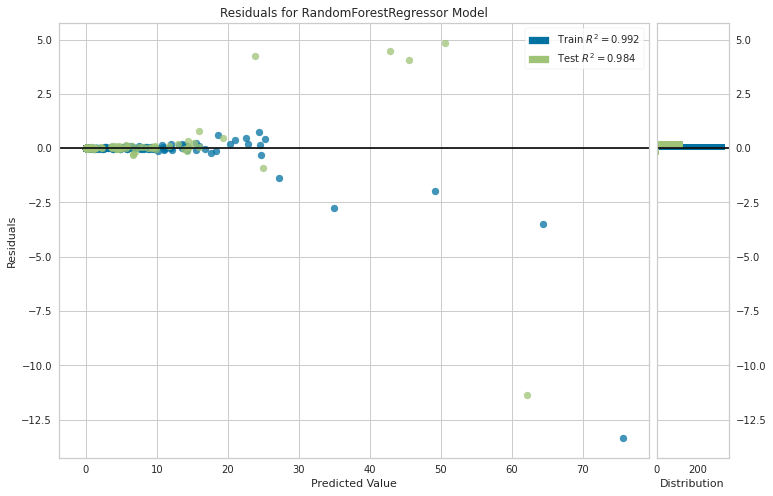

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [198]:
from yellowbrick.regressor import ResidualsPlot
fig, ax = plt.subplots (figsize = (12, 8))
rpv = ResidualsPlot (rfr)
rpv.fit (bos_X_train, bos_y_train)
rpv.score (bos_X_test, bos_y_test)
rpv.poof ()

**Normal Residuals**

<AxesSubplot:title={'center':'Residual Histogram'}, ylabel='Frequency'>

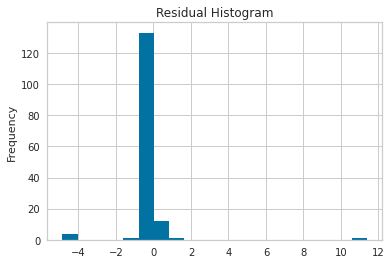

In [199]:
fig, ax = plt.subplots (figsize = (6, 4))
resids = bos_y_test - rfr.predict (bos_X_test)
pd.Series(resids, name = "residuals").plot.hist (bins = 20, ax = ax, title = "Residual Histogram")

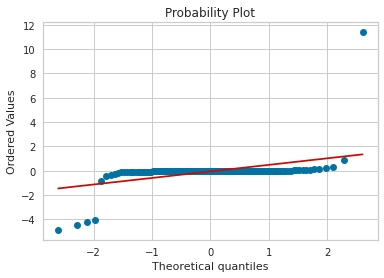

In [200]:
# show the propbability plot
from scipy import stats
gig, ax = plt.subplots (figsize = (6, 4))
_ = stats.probplot (resids, plot = ax)

In [201]:
stats.kstest (resids, cdf = "norm")

KstestResult(statistic=0.4422373931928154, pvalue=1.3446391814113443e-27)

**Prediction error plot**

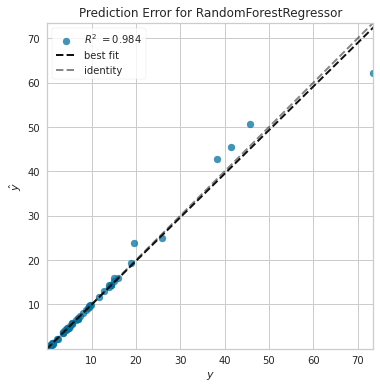

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [202]:
from yellowbrick.regressor import PredictionError
fig, ax = plt.subplots (figsize = (6, 6))
pev = PredictionError (rfr)
pev.fit (bos_X_train, bos_y_train)
pev.score (bos_X_test, bos_y_test)
pev.poof ()

**Dimensionality reduction**

In [203]:
ti_df = tweak_titanic (orig_df)
std_cols = "Pclass".split (",")
X_train, X_test, y_train, y_test = get_train_test_X_y (ti_df, "Survived", std_cols = std_cols)
X = pd.concat ([X_train, X_test])
y = pd.concat ([y_train, y_test])

**Principal component analysis (PCA)**

In [204]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA (random_state = 42)
X_pca = pca.fit_transform (StandardScaler ().fit_transform (X))
pca.explained_variance_ratio_

array([0.23129488, 0.2293505 , 0.19375526, 0.10479671, 0.08188812,
       0.06619362, 0.05126796, 0.04145295])

In [ ]:
pca.components_[0]

[Text(0.5, 0, 'Component'),
 Text(0, 0.5, 'Percent of Explained variance'),
 Text(0.5, 1.0, 'Scree Plot'),
 (0.0, 1.0)]

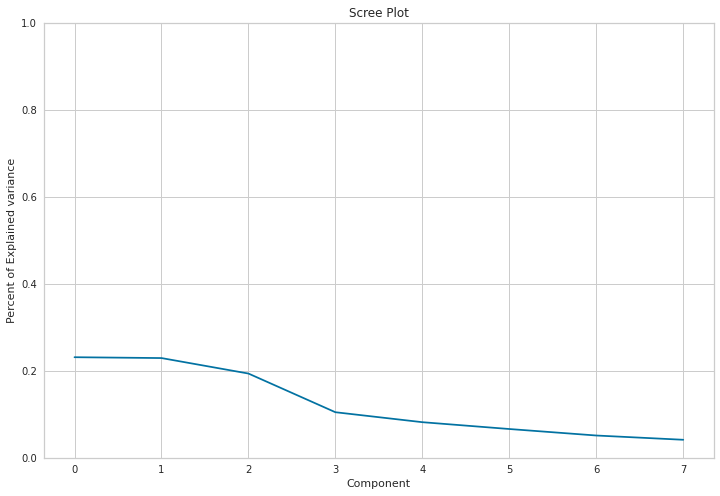

In [205]:
fig, ax = plt.subplots (figsize = (12, 8))
ax.plot (pca.explained_variance_ratio_)
ax.set (xlabel = "Component", ylabel = "Percent of Explained variance",
       title = "Scree Plot", ylim = (0, 1))